In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing
import sklearn.neural_network
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob

## Expresiones faciales en lenguaje de señas

Este dataset contiene datos correspondientes a 8 tipos de gestos faciales que se usan en algunas expresiones del lenguaje de señas brasileño. Se tienen por lo menos 660 ejemplos de cada tipo de expresión facial, provenientes de videos tomados de dos personas distintas, cada una de ellas haciendo un monólogo en lenguaje de señas que incluía dicha expresión.

Cada instancia consiste de las coordenadas (en tres dimensiones) de 100 puntos de interés del rostro del hablante, para un total de 300 datos por instancia. 

In [2]:
datapoints = np.sort(glob.glob('Datasets/*datapoints.txt')) # Cada archivo contiene todos las instancias de una misma categoría
positive = np.sort(glob.glob('Datasets/*targets.txt')) # Indica si la instancia corresponde al gesto esperado o es sólo un gesto neutro
target = []
datos = []
K = 8

for i in range(len(positive)):
    gesto = np.loadtxt(positive[i])
    categoria = np.loadtxt(datapoints[i],skiprows=1)[np.where(gesto==1)] #Coge sólo las instancias donde hay gesto
    categoria = categoria[:330] # Corta la cantidad de instancias, para que todas las categorías estén igualmente representadas
    for j in range(len(categoria)):
        dato = categoria[j]
        datos.append(dato[1:]) # Descarta el primer dato (no es relevante)
        target.append(i%K)
datos = np.array(datos,dtype=float)

In [3]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(datos, target, test_size=0.5)

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
clf = LogisticRegression(C=50, penalty='l1', solver='saga', tol=0.1)
clf.fit(X_train, Y_train)

f1_log = metrics.f1_score(Y_test, clf.predict(X_test), average='macro')

In [5]:
neuronas = np.arange(1,K+1)
#loss = []
f1_test = []
#f1_train = []
it = 2500

for i in neuronas:
    mlp = sklearn.neural_network.MLPClassifier(activation='logistic',hidden_layer_sizes=(i),max_iter=it)
    mlp.fit(X_train, Y_train)
    
    #loss.append(mlp.loss_)
    f1_test.append(metrics.f1_score(Y_test, mlp.predict(X_test), average='macro'))
    #f1_train.append(metrics.f1_score(Y_train, mlp.predict(X_train), average='macro'))

In [13]:
neuronas1 = np.arange(1,K/2+1,dtype=int)
neuronas2 = np.arange(2,K+1)
#loss = []
f1_test2 = np.zeros((len(neuronas1),len(neuronas2)))
#f1_train = []
it = 2500


for i in range(len(neuronas1)):
    for j in range(len(neuronas2)):
        
        mlp = sklearn.neural_network.MLPClassifier(activation='logistic',hidden_layer_sizes=(neuronas1[i],neuronas2[j]),max_iter=it)
        mlp.fit(X_train, Y_train)
        
        f1_test2[i,j]=metrics.f1_score(Y_test, mlp.predict(X_test), average='macro')
        #f1_train.append(metrics.f1_score(Y_train, mlp.predict(X_train), average='macro'))

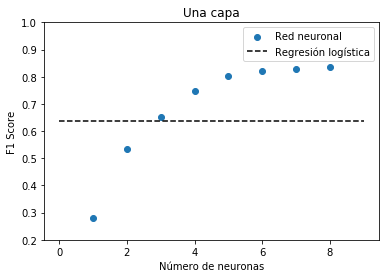

In [14]:
plt.figure()
plt.scatter(neuronas,f1_test,label='Red neuronal')
plt.hlines(f1_log,0,K+1,linestyles='dashed',label='Regresión logística')
plt.xlabel('Número de neuronas')
plt.ylabel('F1 Score')
plt.ylim(0.2,1)
plt.legend()
plt.title('Una capa')
plt.show()

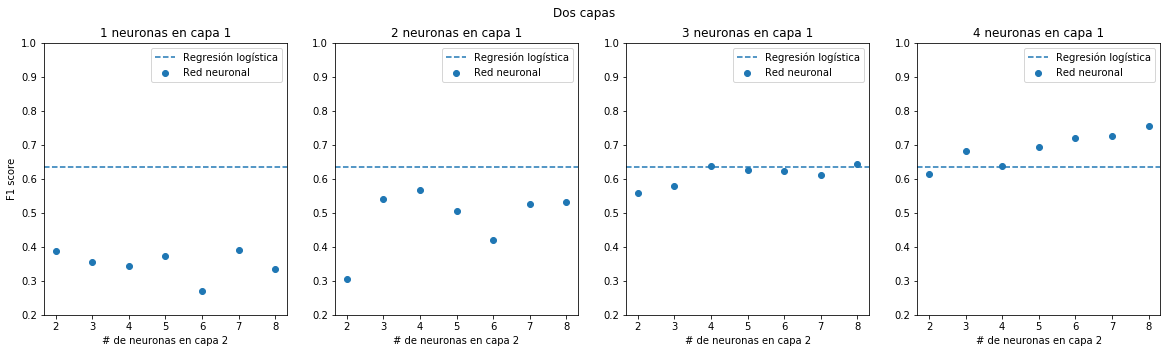

In [15]:
fig,axes = plt.subplots(1,len(neuronas1),figsize=(20,5))

for i in range(len(neuronas1)):
    axes[i].scatter(neuronas2,f1_test2[i],label='Red neuronal')
    axes[i].axhline(f1_log,0,K+1,linestyle='--',label='Regresión logística')
    axes[i].set_title('{} neuronas en capa 1'.format(i+1))
    axes[i].set_xlabel('# de neuronas en capa 2')
    axes[i].set_ylim([0.2,1])
    axes[i].legend()
    
axes[0].set_ylabel('F1 score')
    
plt.suptitle('Dos capas')
plt.show()

## Discusión

De las gráficas anteriores se observa que la red de una capa alcanzó a superar el F1 de la regresión logística cuando se usaban por lo menos 3 neuronas. En el caso de las redes de dos capas, las redes que tenían una o dos neuronas en la capa uno no superaron el F1 de la regresión logística, sin importar el número de neuronas en la segunda capa; de igual manera entre las redes con 3 neuronas en la primera capa las únicas que superó ese F1 fueron la que tenía 8 neuronas en la capa dos. Las redes con cuatro neuronas en la capa uno tuvieron mejores resultados, superando el F1 de la regresión logística con tan solo 2 neuronas en la capa dos.

Si bien hay una tendencia gneral de mejoría a medida que se incrementa el número de neuronas en la capa dos, esta tendencia no es absoluta: en algunos casos se observa una caída en el F1 cuando hay incremento de neuronas. Esto contrasta con el modelo de una capa, donde un incremento en neuronas siempre implicó mejoría en las predicciones. Igualmente, se observa que en varios caso - para un mismo número de neuronas de la capa uno - usar una segunda capa disminuye el score F1 con respecto al modelo con una sola capa. De hecho, el mejor score se obtuvo con la red de una capa de 8 neuronas.